In [4]:
# default_exp dataloaders

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataloaders
> Dataloaders for decode

In [6]:
from pathlib import Path
from nbdev_template.utils import tiff_imread, show_image
import torch
from nbdev_template.transforms import ScaleTensor, RandomCrop3D
from nbdev_template.pointsource import PointSourceGaussian
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#export
import torch

In [8]:
#export
class DecodeDataset:
    def __init__(self, tiff_stack: torch.Tensor, dataset_tfms: list, gen_tfms: list, num_iter = 5000):
        self.imgs = tiff_stack
        self.dataset_tfms = dataset_tfms
        self.gen_tfms   = gen_tfms
        self.num_iter = num_iter
    
    def __len__(self):
        return self.num_iter
   
    def __getitem__(self, _):
        x = self._compose(self.imgs, self.dataset_tfms)
        gen_x = self._compose(x, self.gen_tfms)
        return x, gen_x
    
    def __repr__(self):
        print (f'{self.__class__.__name__} Summary:')
        print (f'tiff image stack: {self.imgs.shape}\n')
        print (f'Dataset tfms: {len(self.dataset_tfms)}')
        for i in self.dataset_tfms:
            print (f'\n-->')
            f"{i}"
        print (f'\nGenerative data tfms: {len(self.gen_tfms)}')
        for i in self.gen_tfms:
            print (f'\n-->')
            f"{i}"
            
        return ''
    
    @staticmethod
    def _compose(x, list_func):
        if not list_func: list_func.append(lambda x: x)
        for func in list_func: x = func(x)
        return x

In [9]:
TRN_IMG_3D_P = Path('/nrs/turaga/smlm_data/SvobodaWang_mFISH/sample.ALM.tif')
#switching from (h, c, w, d) to (c, h, w, d) and only using 1 channel since its our data
TRN_IMG_3D = torch.tensor(tiff_imread(TRN_IMG_3D_P).astype('float32')).permute(1, 0, 2, 3)[1].unsqueeze(0);
norma = ScaleTensor(low=0.0, high=1.0, data_min = TRN_IMG_3D.min(), data_max = TRN_IMG_3D.max())

In [10]:
TRN_IMG_3D_norma = norma(TRN_IMG_3D)

In [11]:
TRN_IMG_3D_norma.min(), TRN_IMG_3D_norma.max()

(tensor(0.), tensor(1.))

In [12]:
data_min = 0.0
data_max = 1.0
low      = 0.001
high     = 0.015
crop_sz = (101, 200, 200)
min_int=0.4

In [13]:
probmap_generator = ScaleTensor(low=low, high=high, data_min = data_min, data_max = data_max)
rand_crop = RandomCrop3D(TRN_IMG_3D_norma.shape, crop_sz)
point_source = PointSourceGaussian(min_int)

In [14]:
ds = DecodeDataset(TRN_IMG_3D_norma.cuda(), dataset_tfms=[rand_crop], gen_tfms=[probmap_generator, point_source], num_iter=10)

In [15]:
ds

DecodeDataset Summary:
tiff image stack: torch.Size([1, 101, 960, 960])

Dataset tfms: 1

-->
Transform(RandomCrop3D)
img_sz: (101, 960, 960)
crop_sz: (101, 200, 200)

Generative data tfms: 2

-->
Transform(ScaleTensor)
low: 0.001
high: 0.015
data_min: 0.0
data_max: 1.0

-->
Transform(PointSourceGaussian)
min_int: 0.4


In [25]:
x, (locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d) = ds[_]

In [26]:
list(map(lambda x: getattr(x, 'size')(), [x, locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d,]))

[torch.Size([1, 101, 200, 200]),
 torch.Size([1, 101, 200, 200]),
 torch.Size([1, 101, 200, 200]),
 torch.Size([1, 101, 200, 200]),
 torch.Size([1, 101, 200, 200]),
 torch.Size([1, 101, 200, 200])]

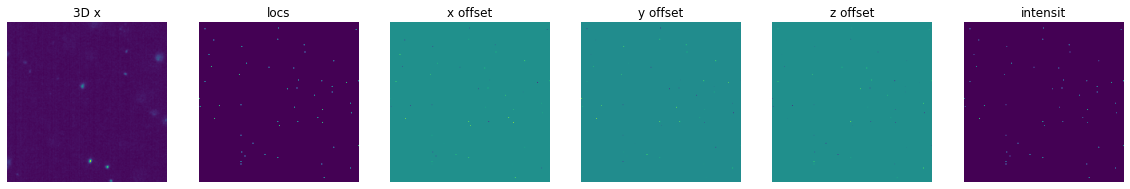

In [27]:
idx = 0
ch = 0
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
show_image(x      .permute(1, 0, 2, 3)[:, ch, :, :][idx], title= '3D x'    , ax = axes[0])
show_image(locs_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'locs'    , ax = axes[1])
show_image(x_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'x offset', ax = axes[2])
show_image(y_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'y offset', ax = axes[3])
show_image(z_os_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'z offset', ax = axes[4])
show_image(ints_3d.permute(1, 0, 2, 3)[:, ch, :, :][idx], title= 'intensit', ax = axes[5])